<a href="https://colab.research.google.com/github/botkin92/Data_analysis_algorithms/blob/lesson_5/Lesson_5_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 5. Случайный лес

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn.model_selection import train_test_split

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

In [ ]:
# def accur(y_true,y_pred, t = 0.5):
#     y_p = (y_pred>t).astype(int)
#     return np.mean(y_p == y_true)

In [ ]:
# from sklearn.linear_model import LogisticRegression

## Реализация случайного леса (из методички)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [ ]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [ ]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [ ]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [ ]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [ ]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [ ]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [ ]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [ ]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

## Домашнее задание 

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [ ]:
# Сгенерируем данные, представляющие собой 100 объектов с 2-мя признаками
data, labels = datasets.make_classification(n_samples=100, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)
# Разобьем выборку на обучающую и тестовую
X_train, X_test, y_train ,y_test = train_test_split(data, labels, test_size = 0.3)

In [ ]:
# # визуализируем сгенерированные данные

# colors = ListedColormap(['red', 'blue'])
# light_colors = ListedColormap(['lightcoral', 'lightblue'])

# plt.figure(figsize=(8,8))
# plt.scatter(list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data)), 
#               c=labels, cmap=colors)
# plt.show()

Построим лес из одного дерева

In [ ]:
n_trees = 1
my_forest_1 = random_forest(X_train, y_train, n_trees)

In [ ]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, X_train)

In [ ]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, X_test)

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 94.286


In [ ]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 86.667


(20174, 0) (20174, 1) (20174, 1)


Text(0.5, 1.0, 'Test accuracy=86.67')

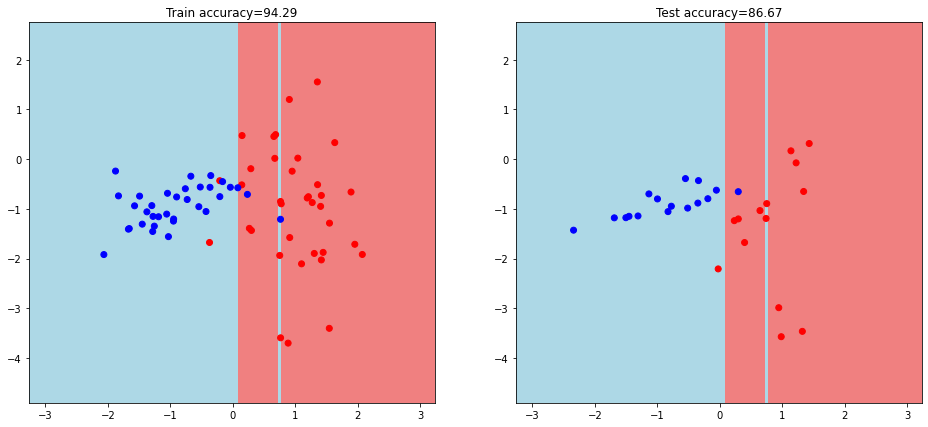

In [ ]:
# Визуализируем дерево на графике

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(X_train)
mesh_predictions = np.array(tree_vote(my_forest_1, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из трех деревьев

In [ ]:
n_trees = 3
my_forest_3 = random_forest(X_train, y_train, n_trees)

In [ ]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, X_train)

In [ ]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, X_test)

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 97.143


In [ ]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 90.000


(20174, 0) (20174, 1) (20174, 1)


Text(0.5, 1.0, 'Test accuracy=90.00')

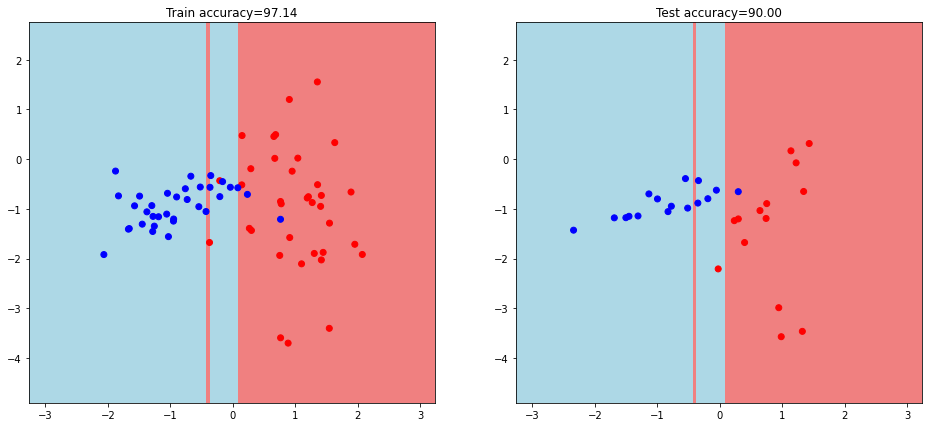

In [ ]:
# Визуализируем дерево на графике

# def get_meshgrid(data, step=.05, border=1.2):
#     x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
#     y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
#     xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
#     x = xx.reshape(-1,1)
#     y = yy.reshape(-1,1)
#     f = np.ones((x.shape[0],data[:, 2:].shape[1]))
#     print(f.shape,x.shape,y.shape)
#     data_gr = np.concatenate((x,y,f),axis=1)
#     return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(X_train)
mesh_predictions = np.array(tree_vote(my_forest_3, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из десяти деревьев

In [ ]:
n_trees = 10
my_forest_10 = random_forest(X_train, y_train, n_trees)

In [ ]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, X_train)

In [ ]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, X_test)

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 100.000


In [ ]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 80.000


(20174, 0) (20174, 1) (20174, 1)


Text(0.5, 1.0, 'Test accuracy=80.00')

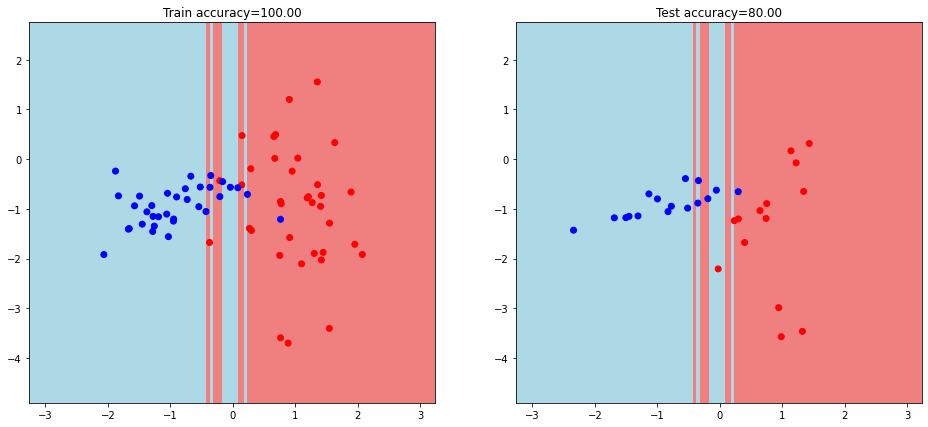

In [ ]:
# Визуализируем дерево на графике

# def get_meshgrid(data, step=.05, border=1.2):
#     x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
#     y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
#     xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
#     x = xx.reshape(-1,1)
#     y = yy.reshape(-1,1)
#     f = np.ones((x.shape[0],data[:, 2:].shape[1]))
#     print(f.shape,x.shape,y.shape)
#     data_gr = np.concatenate((x,y,f),axis=1)
#     return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(X_train)
mesh_predictions = np.array(tree_vote(my_forest_10, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из пятидесяти деревьев

In [ ]:
n_trees = 50
my_forest_50 = random_forest(X_train, y_train, n_trees)

In [ ]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, X_train)

In [ ]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, X_test)

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [ ]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 80.000


(20174, 0) (20174, 1) (20174, 1)


Text(0.5, 1.0, 'Test accuracy=80.00')

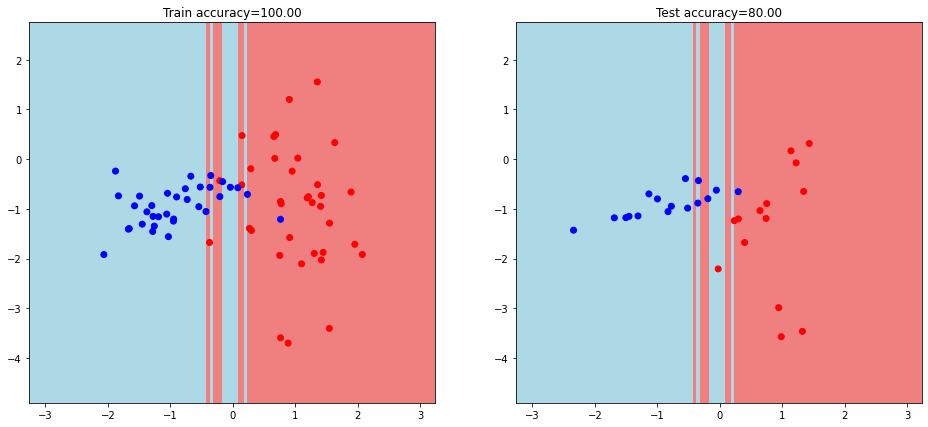

In [ ]:
# Визуализируем дерево на графике

# def get_meshgrid(data, step=.05, border=1.2):
#     x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
#     y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
#     xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
#     x = xx.reshape(-1,1)
#     y = yy.reshape(-1,1)
#     f = np.ones((x.shape[0],data[:, 2:].shape[1]))
#     print(f.shape,x.shape,y.shape)
#     data_gr = np.concatenate((x,y,f),axis=1)
#     return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(X_train)
mesh_predictions = np.array(tree_vote(my_forest_50, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

В данном примере можно сказать, что гиперплоскости получились достаточно простыми. Все разбиения происходят вдоль одного признака. С увеличением числа деревьев увеличивается переобучение.

3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Дополним функцию get_bootstrap поиском отложенной выборки, т.е. те элементы которые не вошли в bootstrap подмножество: 

In [ ]:
random.seed(42)

def get_bootstrap_oob(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    oob = []  # Список, аналогичный списку bootstrap, для отложенной выборки 

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        smplist_index = []  # список индексов для bootstrap выборки
        outlist_index = []  # список индексов для отложенной выборки
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            smplist_index.append(sample_index)  # запишем индекс в список
        bootstrap.append((b_data, b_labels))

        for ind in range(n_samples):
            if ind not in smplist_index:  # если индекс не принадлежит bootstrap выборки, то присвоем его к отложенной 
                outlist_index.append(ind)
        oob.append((data[outlist_index], labels[outlist_index]))
    
    return bootstrap, oob

In [ ]:
# Скорректируем random_forest, добавив пустую переменную:
def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap, _ = get_bootstrap_oob(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

Рассчитаем точность на обучающей выборке

In [ ]:
n_trees = 1
my_forest_oob_1 = random_forest_oob(X_train, y_train, n_trees)

In [ ]:
bootstrap, oob = get_bootstrap_oob(X_train, y_train, n_trees)

In [ ]:
for b_data, b_labels in bootstrap:
    X_b = b_data
    y_b = b_labels

In [ ]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_oob_1, X_b)

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_b, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 94.286


Проверим точность на отложенной выборке для леса из одного дерева

In [ ]:
for oob_data, oob_labels in oob:
    X_oob = oob_data
    y_oob = oob_labels

In [ ]:
# Получим ответы для отложенной выборки 
oob_answers = tree_vote(my_forest_oob_1, X_oob)

In [ ]:
# Точность на отложенной выборке
oob_accuracy = accuracy_metric(y_oob, oob_answers)
print(f'Точность случайного леса из {n_trees} деревьев на отложенной выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на отложенной выборке: 92.000


4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.

In [ ]:
# Расчет критерия Джини

# def gini(labels):
#     #  подсчет количества объектов разных классов
#     classes = {}
#     for label in labels:
#         if label not in classes:
#             classes[label] = 0
#         classes[label] += 1
    
#     #  расчет критерия
#     impurity = 1
#     for label in classes:
#         p = classes[label] / len(labels)
#         impurity -= p ** 2
        
#     return impurity

In [ ]:
# Расчет критерия энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    shannon_ent = 0
    for label in classes:
        p = classes[label] / len(labels)
        shannon_ent -= p * np.log2(p)
      
    return shannon_ent

In [ ]:
# Расчет качества

def quality(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

Построим лес из трех деревьев с критерием Шеннона

In [ ]:
n_trees = 3
my_forest_3 = random_forest(X_train, y_train, n_trees)

In [ ]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, X_train)

In [ ]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, X_test)

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 95.714


In [ ]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 90.000


(20174, 0) (20174, 1) (20174, 1)


Text(0.5, 1.0, 'Test accuracy=90.00')

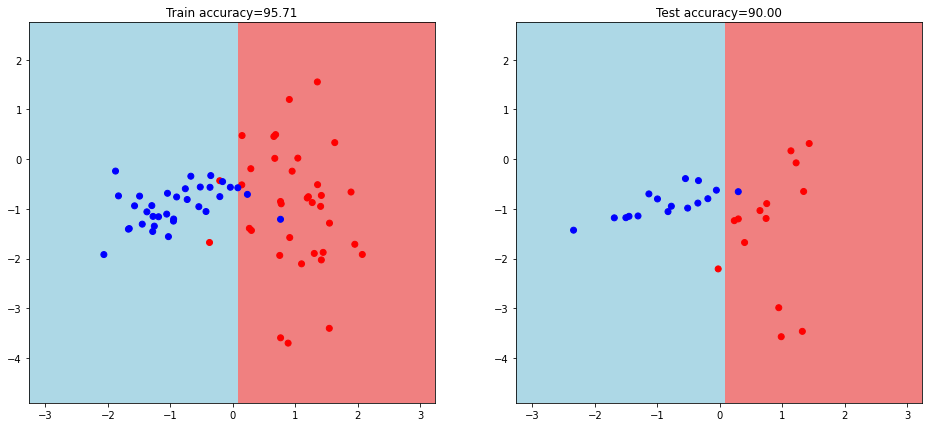

In [ ]:
# Визуализируем дерево на графике

# def get_meshgrid(data, step=.05, border=1.2):
#     x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
#     y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
#     xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
#     x = xx.reshape(-1,1)
#     y = yy.reshape(-1,1)
#     f = np.ones((x.shape[0],data[:, 2:].shape[1]))
#     print(f.shape,x.shape,y.shape)
#     data_gr = np.concatenate((x,y,f),axis=1)
#     return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(X_train)
mesh_predictions = np.array(tree_vote(my_forest_3, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построенный лес с критерием Шеннона получил меньшее число гиперплоскостей, хотя результаты схожи с лесом по Джини. Признаки и пороги, выбранные при разбиении также схожи с реализацией по Джини.